In [ ]:
%%writefile generador_archivo_datos.c
#include<stdio.h>
#include<stdlib.h>
#include<time.h>
// ---> argv[1]: Nombre del archivo a generar <---
// ---> argv[2]: numero de datos a generar    <---
int main(int argc, char*argv[]){
  FILE *fp;
  int n,*datos, i;
  
  n = atoi(argv[2]);
  fp = fopen(argv[1], "w");
  if(fp){
    srand(time(NULL));
    fprintf(fp,"%d\n",n);
    for(i = 0; i < n; i++)
      fprintf(fp,"%d\n",rand()%100);
    
    fclose(fp);
  }
  
    return 0;
}

Overwriting generador_archivo_datos.c


In [ ]:
%%script bash
echo "Genera Archivo de Datos"
gcc generador_archivo_datos.c -o generar
./generar datos.dat 100000000

In [ ]:
%%writefile myheader.h
#include <stdlib.h>
#include "mpi.h"
#include <stdio.h>
#include <math.h> // ceil()
#include <limits.h> // INT_MAX 

#define BLOCK_LOW(id,p,n) ((id)*(n)/(p))
#define BLOCK_HIGH(id,p,n) (BLOCK_LOW((id)+1,p,n)-1)
#define BLOCK_SIZE(id,p,n)(BLOCK_HIGH(id,p,n)-BLOCK_LOW(id,p,n)+1)

void mezcla(int* v1, int n1,int *v2, int n2){
    int *aux = NULL;
    // Pedimos memoria al arreglo auxilar
    int ntotal = n1 + n2;
    int i;
    aux = (int*) malloc(ntotal*sizeof(int));
    if(aux == NULL){
        printf("No hay memoria\n");
        MPI_Abort(MPI_COMM_WORLD, 99);
    }

    for (i = 0; i < n1; i++){
        aux[i] = v1[i];
    }


    int a = 0; // Indice que recorre la primera parte del arreglo
    int b = 0; // Indice que recorre la segunda parte del arreglo
    i=0;

    // Mientras algun índice no llegue a la parte final que recorren
    while (a < n1 && b < n2){
        if(aux[a] <= v2[b]){
            v1[i] = aux[a];
            a++;
        }else{
            v1[i] = v2[b];
            b++;
        }
        i++;
    }
    // Si el indice b llegó al final de su arreglo
    if(b == n2){
        // Asignamos los numeros restantes
        while (i < ntotal){
            v1[i] = aux[a];
            a++;
            i++;
        }
    }
    free(aux);
}

int compare(const void *_a, const void *_b){
  int *a, *b;
  a = (int *) _a;
  b = (int *) _b;
  return (*a - *b);
}

int read_array(char* fname, int **arr, int np) {
  FILE *myFile;
  unsigned int i, n, chunksize, faltantes;

  myFile = fopen(fname, "r");
  if(!myFile){
    printf("ERROR: No se pudo abrir el archivo %s",fname);
    MPI_Abort(MPI_COMM_WORLD, 99);
  }

  fscanf(myFile, "%i\n", &n); // número de datos

  *arr = (int *) malloc( n * sizeof(int) );
  if (*arr == NULL) {
    printf("Memoria insuficiente\n");
    MPI_Abort(MPI_COMM_WORLD, 99);
  }

  for (i = 0; i < n; i++)
    fscanf(myFile, "%i\n", (*arr)+i);

  return n;
}

Overwriting myheader.h


In [ ]:
%%writefile psrs.c
#include "myheader.h"

int main(int argc, char**argv){
  int id, np, root, *sendbuf, *recvbuf, *arreglo, *muestras, *recvbuf_mezcla, *todas_las_muestras, *pivote;
  unsigned int n, n_r, i, j, n_local, *displs, *sendcounts, *recvcounts, *sdispls, *rdispls, ndatos_recv;
  double t1, t2;

  MPI_Init(&argc, &argv);
  MPI_Comm_size(MPI_COMM_WORLD, &np); // Numero total de procesos
  MPI_Comm_rank(MPI_COMM_WORLD, &id); // Valor de nuestro identificador

  MPI_Barrier(MPI_COMM_WORLD);  // sincronización
  t1 = MPI_Wtime();

  //El root lee un conjunto de datos del archivo con n datos e inicia una dispersión de los datos.
  root = np - 1;
  if(id == root){ // Lee los datos del archivo
    n = read_array(argv[1], &sendbuf, np);
    /*printf("\nDatos a distribuir");
    printf("\nsendbuf={");
    for(i = 0; i < n; i++)
    printf("%d, ",sendbuf[i]);
    printf("}\n");*/
  }

  sendcounts = (int*)malloc(np*sizeof(int));
  if(sendcounts == NULL){
    printf("Memoria insuficiente (sendcounts) \n");
    MPI_Abort(MPI_COMM_WORLD, 99);
  }

  if(id == root){
    for(i = 0; i < np; i++)
      sendcounts[i] = BLOCK_SIZE(i, np, n);

      /*printf("\n[%d] sendcounts={",id);
        for(i = 0; i < np; i++) 
        printf("%d, ", sendcounts[i]); 
        printf("}\n"); */

  displs = (int*)malloc(np*sizeof(int));
  if(displs == NULL){
    printf("ERROR: Memoria insuficiente(displs)");
    MPI_Abort(MPI_COMM_WORLD,99);
  }
  displs[0] = 0;
  for(i = 1; i < np; i++)
    displs[i] = displs[i-1] + sendcounts[i-1];
  }
  
  // Comunica longitud de los chunks
  MPI_Bcast(&n, 1, MPI_UNSIGNED, root, MPI_COMM_WORLD);
  n_local = BLOCK_SIZE(id, np, n);

  recvbuf = (int *)malloc(n_local*sizeof(int));
  if(recvbuf == NULL){
    printf("Memoria insuficiente(recvbuf)");
    MPI_Abort(MPI_COMM_WORLD, 99);
  }

  MPI_Scatterv(sendbuf, sendcounts, displs, MPI_INT, recvbuf, n_local, MPI_INT, root, MPI_COMM_WORLD);

   /*if (id==0) {
     printf("\n[%d]recvbuf={",id); 
     for(i = 0; i < n_local; i++)
     printf("%d, ", recvbuf[i]);
     printf("}\n");} */
  
  // Cada proceso ordena localmente sus datos con Ordenamiento Rapido(Quicksort)
  qsort(recvbuf, n_local, sizeof(int), &compare);

  /*if (id==2) {
     printf("\n[%d] ordenado recvbuf={",id);
       for(i = 0; i < n_local; i++)
       printf("%d, ", recvbuf[i]); 
       printf("}\n"); } */
  
  //Cada proceso selecciona los n indices 0, n/p^2, 2n/p^2, 3n/p^2,..., (p-1)n/p^2 como muestras regulares
  muestras = (int*)malloc(np*sizeof(int));
  if(muestras == NULL){
    printf("Memoria insuficiente(muestras)");
    MPI_Abort(MPI_COMM_WORLD, 99);
  }

  for(i = 0; i < np; i++)
  muestras[i] = recvbuf[i*n/(np*np)];

  /*if (id==0) {
     printf("\n[%d] muestras={",id);
     for(i=0;i<np;i++)
     printf("%d, ", muestras[i]);
     printf("}\n"); } */

  // Un proceso recolecta y ordena las muestras regulares y selecciona p-1 valores pivote de la lista ordenada. <-----  (4)
  // Los valores pivote están en los índices p+p/2-1, 2p+p/2-1, 3p+p/2-1, ... , (p-1)p+p/2-1.   
  // Los valores pivote son dados a conocer a todos los procesos.

  if(id == root){
    todas_las_muestras = (int*)malloc(np*np*sizeof(int));
    if(todas_las_muestras == NULL){
      printf("Memoria insuficiente(todas_las_muestras)\n");
      MPI_Abort(MPI_COMM_WORLD ,99);
    }
  }

  MPI_Gather(muestras, np, MPI_INT, todas_las_muestras, np, MPI_INT, root, MPI_COMM_WORLD);

  if(id == root){
    qsort(todas_las_muestras, np*np, sizeof(int), &compare);
    /*printf("\n[%d] todas_las_muestras={",id);
      for(i=0;i<np*np;i++)
      printf("%d, ", todas_las_muestras[i]);
      printf("}\n"); */
    }

    pivote = (int*)malloc((np - 1)*sizeof(int));
    if(pivote == NULL){
      printf("Memoria insuficiente(pivote)\n");
      MPI_Abort(MPI_COMM_WORLD, 99);
    }
    if(id == root){
      for(i = 0; i < np - 1; i++)
      pivote[i] = todas_las_muestras[(i+1)*np + np/2 -1];
    }
    /*if (id==root) {
      printf("\n[%d] pivote={",id);
      for(i=0;i<np-1;i++)
      printf("%d, ", pivote[i]);
      printf("}\n"); } */
    
    MPI_Bcast(pivote, np - 1, MPI_INT, root, MPI_COMM_WORLD);

    //Cada proceso particiona la sublista ordena en p piezas disjuntas, usando los valores pivote como separadores.
    j = 0;
    for(i = 0; i < (np - 1); i++){
      sendcounts[i] = 0;
      while(recvbuf[j] <= pivote[i] && j < n_local){
        sendcounts[i]++;
        j++;
      }
    }
    sendcounts[np - 1] = 0;
    while(j < n_local){
      sendcounts[np - 1]++;
      j++;
    }
    /*if(id==0){
       printf("\n[%d] sendcounts={",id);
       for(i=0;i<np;i++)
       printf("%d, ", sendcounts[i]);
       printf("}\n"); } */

    sdispls = (int*)malloc(np*sizeof(int));
    if(sdispls == NULL){
      printf("Memoria insuficiente (sdispls) \n");
      MPI_Abort(MPI_COMM_WORLD, 99);
    }

    sdispls[0] = 0;
    for(i = 1; i < np; i++)
    sdispls[i] = sdispls[i - 1]+sendcounts[i - 1];
    /*if(id==0){
      printf("\n[%d] sdispls={",id);
      for(i=0;i<np;i++)
      printf("%d, ", sdispls[i]);
      printf("}\n"); } */
  
  recvcounts = (int*)malloc(np*sizeof(int));
  if(recvcounts == NULL){
    printf("Memoria insuficiente (recvcounts) \n");
    MPI_Abort(MPI_COMM_WORLD, 99);
  }

  MPI_Alltoall(sendcounts, 1, MPI_INT, recvcounts, 1, MPI_INT, MPI_COMM_WORLD);

  rdispls = (int*)malloc(np*sizeof(int));
  if(rdispls == NULL){
    printf("Memoria insuficiente (rdispls) \n");
    MPI_Abort(MPI_COMM_WORLD, 99);
  }

  rdispls[0] = 0;
  for(i = 1; i < np; i++)
  rdispls[i] = rdispls[i-1] + recvcounts[i-1];

  /*if(id==0){
    printf("\n[%d] rdispls={",id);
    for(i = 0; i < np; i++)
    printf("%d, ", rdispls[i]);
    printf("}\n"); } */

    ndatos_recv = 0;
    for(i = 0; i < np; i++)
    ndatos_recv += recvcounts[i];

    recvbuf_mezcla = (int*)malloc(ndatos_recv *sizeof(int));
    if(recvbuf_mezcla == NULL){
      printf("Memoria insuficiente(recvbuf_mezcla)\n");
      MPI_Abort(MPI_COMM_WORLD, 99);
    }

    //Cada proceso Pi mantiene su iesima partición y envía la j-partición al proceso Pj (alltoallv)
      MPI_Alltoallv(recvbuf, sendcounts, sdispls, MPI_INT, recvbuf_mezcla, recvcounts, rdispls, MPI_INT, MPI_COMM_WORLD);

    /*if(id==0){
      printf("\n[%d] recvbuf_mezcla={",id);
      for(i = 0; i < ndatos_recv; i++)
      printf("%d, ", recvbuf_mezcla[i]); 
      printf("}\n"); } */

    // Cada proceso mezcla sus p particiones para obtener una sola lista
    n_r = recvcounts[0];
    for(i = 1; i < np; i++){
      mezcla(recvbuf_mezcla, n_r, recvbuf_mezcla + rdispls[i], recvcounts[i]);
      n_r += recvcounts[i];
    }

    // Recolectar los elementos que tiene cada proceso en un solo proceso con fines de impresión
    MPI_Gather(&ndatos_recv, 1, MPI_INT, recvcounts, 1, MPI_INT, root, MPI_COMM_WORLD);
    if(id == root){
      rdispls[0] = 0;
      for(i = 1; i < np; i++)
      rdispls[i] = rdispls[i-1] + recvcounts[i-1];
    }

    MPI_Gatherv(recvbuf_mezcla, ndatos_recv, MPI_INT, sendbuf, recvcounts, rdispls, MPI_INT, root, MPI_COMM_WORLD);

    /*if(id == root){ 
      printf("\nDatos ordenados = {");  
      for(i=0;i<n;i++) 
      printf("%d, ", sendbuf[i]);
      printf("}\n"); } */
    
    //Libera Memoria
    if(id == root){
      free(sendcounts);
      free(displs);
      free(todas_las_muestras);
    }
    free(recvbuf);
    free(muestras);
    free(pivote);

    MPI_Barrier(MPI_COMM_WORLD);
    t2 = MPI_Wtime();

    if(id == root){
      printf("%d\t %.10f \n",np, t2-t1);
    }
    MPI_Finalize();
    return 0;
}

Overwriting psrs.c


In [ ]:
%%script bash
mpicc psrs.c -o psrs -lm
#rm datos.dat   
echo "Ordenamiento de Muestreo Regular"
for i in $(seq 1 16)
do
    echo " ----- Usando $i procesos"
    mpirun --allow-run-as-root -np $i psrs datos.dat    
done

Ordenamiento de Muestreo Regular
 ----- Usando 1 procesos
1	 20.8477377330 
 ----- Usando 2 procesos
2	 23.7246117920 
 ----- Usando 3 procesos
3	 29.5127104120 
 ----- Usando 4 procesos
4	 34.9524220440 
 ----- Usando 5 procesos
5	 41.3278376780 
 ----- Usando 6 procesos
6	 47.2212774470 
 ----- Usando 7 procesos
7	 56.3231602530 
 ----- Usando 8 procesos
8	 61.6384303240 
 ----- Usando 9 procesos
9	 69.3053511410 
 ----- Usando 10 procesos
10	 72.8286242060 
 ----- Usando 11 procesos
11	 78.5739408060 
 ----- Usando 12 procesos
12	 85.7949069140 
 ----- Usando 13 procesos
13	 107.0488226480 
 ----- Usando 14 procesos
14	 98.0391968380 
 ----- Usando 15 procesos
15	 104.9879466990 
 ----- Usando 16 procesos
16	 110.6347117960 


In [2]:
%matplotlib inline

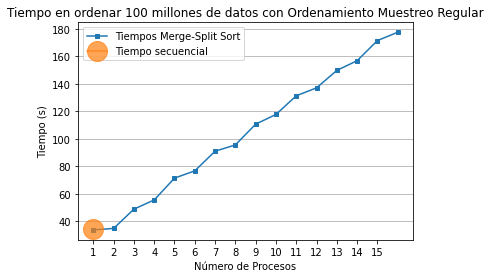

In [4]:
import matplotlib.pyplot as plt
import numpy as np
tiempo_secuencial = 34.095486

procesos = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
tiempos_mr = np.array([20.8477377330,23.7246117920,29.5127104120,34.9524220440,41.3278376780,
                       47.2212774470,56.3231602530,61.6384303240,69.3053511410,72.8286242060,
                       78.5739408060,85.7949069140,107.0488226480,98.0391968380,104.9879466990,110.6347117960])

tiempos_ms = np.array([33.7450496740,34.8315266020,48.8471598560,55.5208529670,71.3873132160,
                       76.6653346670,90.9452396860,95.5078100360,110.6076294930,117.6506313260,
                       131.2223169430,136.9759305740,149.6576050840,156.7285753920,171.3213518920,177.4025252280])  

fig, ax = plt.subplots()
ax.plot(procesos,tiempos_mr,marker='s',label='Tiempos Muestreo Regular',markersize=4)
ax.plot(procesos,tiempos_ms,marker='s',label='Tiempos Merge-Split Sort',markersize=4)

ax.plot([1],[tiempo_secuencial],marker='o',markersize=20,alpha=0.7,label='Tiempo secuencial')
ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Número de Procesos')
plt.ylabel('Tiempo (s)')
plt.title('Tiempo en ordenar 100 millones de datos con Ordenamiento Muestreo Regular')

plt.legend()
plt.savefig('Tiempos_Ordenamientos.png')
plt.show()

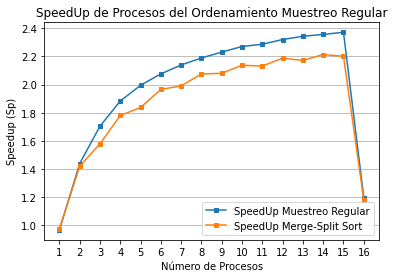

In [ ]:
speedup_mr = tiempo_secuencial / tiempos_mr
speedup_ms = tiempo_secuencial / tiempos_ms

fig, ax = plt.subplots()

ax.plot(procesos,speedup_mr,marker='s',label='SpeedUp Muestreo Regular',markersize=4)
ax.plot(procesos,speedup_ms,marker='s',label='SpeedUp Merge-Split Sort',markersize=4)

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Speedup (Sp)')
plt.title('SpeedUp de Procesos del Ordenamiento Muestreo Regular')

plt.legend()
plt.savefig('SpeedUp_Muestreo_Regular.png')
plt.show()

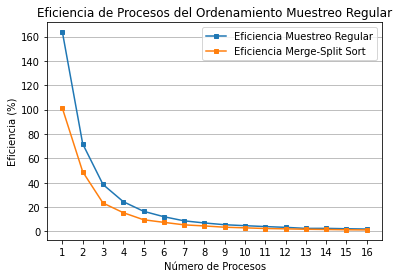

In [ ]:
eficiencia_mr = speedup_mr / procesos*100
eficiencia_ms = speedup_ms / procesos*100

fig, ax = plt.subplots()

ax.plot(procesos,eficiencia_mr,marker='s',label='Eficiencia Muestreo Regular',markersize=4)
ax.plot(procesos,eficiencia_ms,marker='s',label='Eficiencia Merge-Split Sort',markersize=4)

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Eficiencia (%)')
plt.title('Eficiencia de Procesos del Ordenamiento Muestreo Regular')

plt.legend()
plt.savefig('Eficiencia_Muestreo_Regular.png')
plt.show()

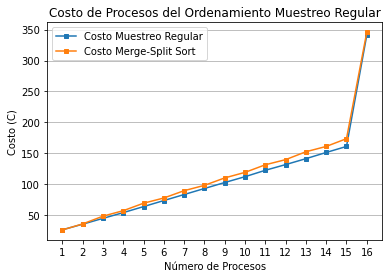

In [ ]:
costo_mr = tiempos_mr * procesos
costo_ms = tiempos_ms * procesos

fig, ax = plt.subplots()

ax.plot(procesos,costo_mr,marker='s',label='Costo Muestreo Regular',markersize=4)
ax.plot(procesos,costo_ms,marker='s',label='Costo Merge-Split Sort',markersize=4)

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Costo (C)')
plt.title('Costo de Procesos del Ordenamiento Muestreo Regular')

plt.legend()
plt.savefig('Costo_Muestreo_Regular.png')
plt.show()

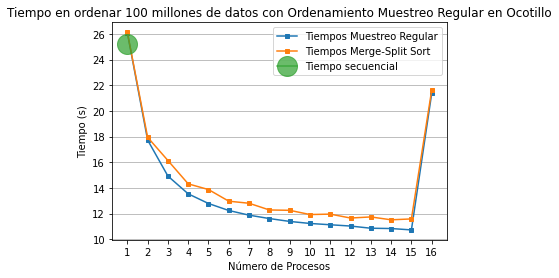

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
tiempo_secuencial = 25.250557

procesos = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
tiempos_mr = np.array([26.1081948802,17.7275557325,14.9186307349,13.5317054822,12.7796168706,
                       12.2344066118,11.8707377967,11.6064773774,11.3823413787,11.2237580328,
                       11.1223447868,11.0216843186,10.8511793031,10.8285047306,10.7201157925,21.3561922818])

tiempos_ms = np.array([26.1315932908,17.9420599493,16.1313092355,14.3112047658,13.8667749547,
                       12.9602878942,12.7982997230,12.2759715541,12.2481125380,11.9189763618,
                       11.9519427306,11.6470923107,11.7321722265,11.5082967862,11.5764610816,21.6099367324])  

fig, ax = plt.subplots()
ax.plot(procesos,tiempos_mr,marker='s',label='Tiempos Muestreo Regular',markersize=4)
ax.plot(procesos,tiempos_ms,marker='s',label='Tiempos Merge-Split Sort',markersize=4)

ax.plot([1],[tiempo_secuencial],marker='o',markersize=20,alpha=0.7,label='Tiempo secuencial')
ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Tiempo (s)')
plt.title('Tiempo en ordenar 100 millones de datos con Ordenamiento Muestreo Regular en Ocotillo')

plt.legend()
plt.savefig('Tiempos_Ordenamientos_Ocotillo.png')
plt.show()

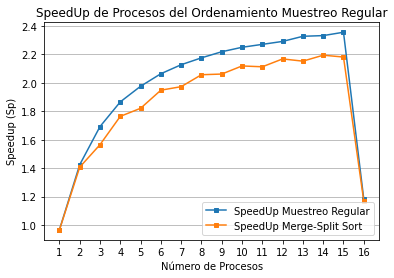

In [ ]:
speedup_mr = tiempo_secuencial / tiempos_mr
speedup_ms = tiempo_secuencial / tiempos_ms

fig, ax = plt.subplots()

ax.plot(procesos,speedup_mr,marker='s',label='SpeedUp Muestreo Regular',markersize=4)
ax.plot(procesos,speedup_ms,marker='s',label='SpeedUp Merge-Split Sort',markersize=4)

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Speedup (Sp)')
plt.title('SpeedUp de Procesos del Ordenamiento Muestreo Regular')

plt.legend()
plt.savefig('SpeedUp_Muestreo_Regular_Ocotillo.png')
plt.show()

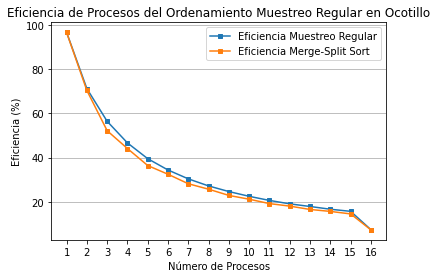

In [ ]:
eficiencia_mr = speedup_mr / procesos*100
eficiencia_ms = speedup_ms / procesos*100

fig, ax = plt.subplots()

ax.plot(procesos,eficiencia_mr,marker='s',label='Eficiencia Muestreo Regular',markersize=4)
ax.plot(procesos,eficiencia_ms,marker='s',label='Eficiencia Merge-Split Sort',markersize=4)

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Eficiencia (%)')
plt.title('Eficiencia de Procesos del Ordenamiento Muestreo Regular en Ocotillo')

plt.legend()
plt.savefig('Eficiencia_Muestreo_Regular_Ocotillo.png')
plt.show()

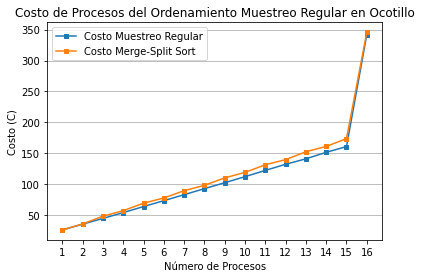

In [ ]:
costo_mr = tiempos_mr * procesos
costo_ms = tiempos_ms * procesos

fig, ax = plt.subplots()

ax.plot(procesos,costo_mr,marker='s',label='Costo Muestreo Regular',markersize=4)
ax.plot(procesos,costo_ms,marker='s',label='Costo Merge-Split Sort',markersize=4)

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Costo (C)')
plt.title('Costo de Procesos del Ordenamiento Muestreo Regular en Ocotillo')

plt.legend()
plt.savefig('Costo_Muestreo_Regular.png')
plt.show()